<a href="https://colab.research.google.com/github/danihga/Jovia/blob/main/CatholicHealth_Unbalanced_DTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dealing with Unbalanced Classes](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [464]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Data Preprocessing
Data Split, Train-test Split, etc...

In [465]:
#Import Data

data = pd.read_excel(r'/Users/familiadelasherasgarciahijosdanielnuriapablo/Documents/Applied Math and Data Science/Jovia/DeidentifiedSDOHPatientData-v1.xlsx')

data.sample(6)

data.columns = ['id', 'age', 'race', 'ethnicity', 'gender',
       'food would run out',
       'Food didn’t last and no money for more',
       'Lack transportation kept from medical appointments or medications?',
       'Lack transportation kept from meetings, work, or things needed for daily living?',
       'Not able to pay the mortgage or rent on time?',
       'Not have a steady place to sleep or slept in a shelter?',
       'Electric, gas, oil, or water company threatened to shut off services?',
       'Fearful of physical/emotional abuse from relative?']

# Only get the first three columns - predictor, and only question column - label
data = data[['age', 'race', 'ethnicity', 'gender',
       'food would run out']]

mapping = {'Never True':0,
       'Sometimes True':1, 'Often True':1}

reverse_mapping = {0:'Never True', 1:'True'}

data['food would run out'] = data['food would run out'].map(mapping)

# Drop NAs

#data = data.dropna()

**No Answer Rows**

In [466]:
ethnicity_yes = data.groupby(by='ethnicity').agg({'age':'mean',
                                                  'food would run out':'sum',
                                                'race':'count'})
ethnicity_yes.columns = ['age', 'n_food_insecure', 'n_patients']
ethnicity_yes['ratio'] = ethnicity_yes['n_food_insecure']/ethnicity_yes['n_patients']
ethnicity_yes

,age,n_food_insecure,n_patients,ratio
ethnicity,,,,
Cuban,70.500000,0.0,2,0.000000
Hispanic or Latino,50.683820,52.0,2157,0.024108
"Mexican, Mexican American, Chicano/a",45.250000,0.0,4,0.000000
Not Hispanic or Latino,67.581948,97.0,13417,0.007230
Patient Refused,45.666667,0.0,6,0.000000
Puerto Rican,67.842105,1.0,19,0.052632
Unknown,61.424370,2.0,238,0.008403


In [467]:
race_yes = data.groupby(by='race').agg({'age':'mean',
                                                  'food would run out':'sum',
                                                'ethnicity':'count'})
race_yes.columns = ['age', 'n_food_insecure', 'n_patients']
race_yes['ratio'] = race_yes['n_food_insecure']/race_yes['n_patients']
race_yes.sort_values(by='ratio',ascending=False)

,age,n_food_insecure,n_patients,ratio
race,,,,
"Black or African American, White or Caucasian",50.000000,2.0,7,0.285714
Patient Refused,54.200000,1.0,5,0.200000
"Other, Unknown",38.000000,1.0,12,0.083333
Black or African American,58.622555,39.0,1738,0.022440
Other,52.276251,43.0,2038,0.021099
...,...,...,...,...
"Japanese, White or Caucasian",52.000000,0.0,1,0.000000
Korean,68.454545,0.0,11,0.000000
Native Hawaiian or Other Pacific Islander,69.600000,0.0,5,0.000000


In [468]:
data.shape

(15843, 5)

In [469]:
data = data[~((data['race'].isin(list(race_yes[race_yes['ratio']==0].index))) | (data['ethnicity'].isin(list(ethnicity_yes[ethnicity_yes['ratio']==0]))))]

In [470]:
data.shape

(15574, 5)

In [471]:
race_ethnicity_no_food_insecure = data.groupby(by=['ethnicity', 'race']).agg({'age':'count',
                                                  'food would run out':'sum'})
race_ethnicity_no_food_insecure.columns = ['n_patients', 'n_food_insecure']
race_ethnicity_no_food_insecure['ratio'] = race_ethnicity_no_food_insecure['n_food_insecure']/race_ethnicity_no_food_insecure['n_patients']
race_ethnicity_no_food_insecure.sort_values(by='ratio',ascending=False)

n_patients  \
ethnicity                            race                                                        
Not Hispanic or Latino               Patient Refused                                         2   
                                     Other, Unknown                                          2   
                                     Black or African American, White or Caucasian           6   
Puerto Rican                         White or Caucasian                                      7   
Unknown                              Black or African American                              20   
Hispanic or Latino                   White or Caucasian, Other                              27   
Unknown                              Unknown                                                29   
Hispanic or Latino                   Other                                                1478   
                                     Black or African American                              37   
Not Hispanic or Latino               Black or African American                            1680   
Hispanic or Latino                   White or Caucasian                                    526   
Not Hispanic or Latino               Asian Indian                                          109   
                                     Other Asian                                           151   
                                     Other                                                 483   
                                     White or Caucasian                                  10724   
Puerto Rican                         Other                                                  12   
Patient Refused                      Black or African American                               1   
Unknown                              Asian Indian                                            1   
Patient Refused                      White or Caucasian, Other                               1   
Unknown                              Other                                                  61   
                                     Other Asian                                             1   
Patient Refused                      White or Caucasian                                      2   
                                     Patient Refused                                         2   
Cuban                                Other                                                   1   
Not Hispanic or Latino               White or Caucasian, Other                              48   
                                     Unknown                                                21   
Cuban                                White or Caucasian                                      1   
Mexican, Mexican American, Chicano/a White or Caucasian                                      1   
                                     Other                                                   3   
Hispanic or Latino                   Unknown                                                 6   
                                     Patient Refused                                         1   
                                     Other, Unknown                                         10   
                                     Other Asian                                             4   
                                     Black or African American, White or Caucasian           1   
Unknown                              White or Caucasian                                    115   

                                                                                    n_food_insecure  \
ethnicity                            race                                                             
Not Hispanic or Latino               Patient Refused                                            1.0   
                                     Other, Unknown                                             1.0   
                                     Black or

In [472]:
data.shape

(15574, 5)

In [473]:
index_to_drop = []
for i in race_ethnicity_no_food_insecure[race_ethnicity_no_food_insecure['ratio']==0].index:
    for j in data.index:
        if data.loc[j]['ethnicity']==i[0] and data.loc[j]['race']==i[1]:
            data.drop(index = j, inplace = True)


In [474]:
data.shape

(15281, 5)

In [475]:
no_food_insecure = {'race':[],'ethnicity':[],'both':[]}

for i in ethnicity_yes[ethnicity_yes['ratio']==0].index:
    no_food_insecure['ethnicity'].append(i)

for i in race_yes[race_yes['ratio']==0].index:
    no_food_insecure['race'].append(i)

for i in race_ethnicity_no_food_insecure[race_ethnicity_no_food_insecure['ratio']==0].index:
    no_food_insecure['both'].append((i[0],i[1]))

In [476]:
# Drop Patient declined, Patient unable to answer
target_rows     = list(data[data['food would run out'].isnull()].index)

**Data Split and Label Encoding**


```
{'Never True':0, 'Sometimes True':1, 'Often True':1}
```



In [503]:
X = data.drop(columns = 'food would run out')

X.index = data.index
y = data['food would run out']
y.index = data.index


print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (15281, 4)
y shape: (15281,)


In [504]:
from sklearn.preprocessing import StandardScaler

categorical_columns = X[['race', 'ethnicity']].copy()

# One-hot encoding for the categorical columns
encoder = OneHotEncoder(sparse_output = False)
categorical_encoded = encoder.fit_transform(categorical_columns)

col_one_hot = list(encoder.get_feature_names_out())
# Convert the one-hot encoded array into a DataFrame with the created column names
one_hot_df = pd.DataFrame(categorical_encoded, columns=col_one_hot)

#scaled_age = (X['age']-X['age'].mean())/X['age'].std()

#one_hot_df['age'] =list(scaled_age)

one_hot_df['age'] = list(X['age'])

X = one_hot_df.copy()

X.index = data.index

predict = X.loc[target_rows]

X = X.drop(index = target_rows)

y = y.loc[X.index]

In [506]:
from sklearn.model_selection import train_test_split

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0, stratify=y)

# Functions

In [507]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn
# define model
def do_grid(X_train, y_train, metric):
  model = DecisionTreeClassifier()

  # define grid
  param_grid = {
      'class_weight': [None, 'balanced',{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
      'max_depth': [None, 1, 2, 3, 4, 5,10],
  }

  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  # define grid search
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric)

  # execute the grid search
  grid_result = grid.fit(X_train, y_train)

  # report the best configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

  # report all configurations
  '''
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))'''

In [508]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc',

In [509]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def dt(X_train, y_train, X_test, y_test, weights={0: 1, 1: 1},max_depth=3):
  model = DecisionTreeClassifier(class_weight=weights,
                                  max_depth=max_depth
                                  ).fit(X_train,y_train)
  #'class_weight': {0: 100, 1: 1}, 'max_depth': None, 'min_samples_leaf': 4
  # Make predictions on the testing data
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print(accuracy_score(y_train, y_train_pred))
  print(accuracy_score(y_test, y_test_pred))
  print(classification_report(y_test, y_test_pred))
  cm = confusion_matrix(y_test, y_test_pred)
  dist= ConfusionMatrixDisplay(cm, display_labels=model.classes_)
  dist.plot()

  return model

# Try Different Sampling Techniques

**Smote**

In [510]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smt_train, y_smt_train = oversample.fit_resample(X_train, y_train)

In [543]:
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred):
    recall_label_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_label_1 = recall_score(y_true, y_pred, pos_label=1)
    precision_label_0 = precision_score(y_true, y_pred, pos_label=0)
    precision_label_1 = precision_score(y_true, y_pred, pos_label=1)
    weighted_recall = 0.8 * recall_label_1 + 0.1 * recall_label_0 +   0.5 * precision_label_0 + 0.5 * precision_label_1# Weighted average with more weight on label 1
    return weighted_recall
scorer = make_scorer(custom_scorer)

In [544]:
do_grid(X_smt_train, y_smt_train, scorer)

/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

Best: 1.668960 using {'class_weight': 'balanced', 'max_depth': None}


0.8911864406779662
0.8848272408612919
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94      3933
         1.0       0.03      0.18      0.05        61

    accuracy                           0.88      3994
   macro avg       0.51      0.54      0.49      3994
weighted avg       0.97      0.88      0.93      3994



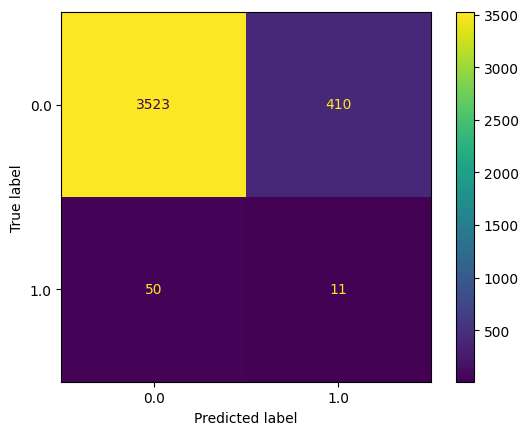

In [545]:
model = dt(X_smt_train, y_smt_train, X_test, y_test, weights='balanced',max_depth=None)

In [170]:
no_answer_pred = model.predict(predict)

In [174]:
pd.Series(no_answer_pred).value_counts(normalize = True)

0.0    0.747957
1.0    0.252043
Name: proportion, dtype: float64